In [39]:
import numpy as np
import pandas as pd
import os

import re
from ast import literal_eval
from tqdm import tqdm
from datetime import datetime as time
from ast import literal_eval
from sklearn.model_selection import train_test_split

import artm
from gensim.models import Phrases
from gensim.models.phrases import Phraser

import gc
import matplotlib.pyplot as plt
%matplotlib inline

# read data

* ## lenta

In [5]:
!ls -lah ../lenta/data/*.bz2

-rw-rw-r-- 1 vtrokhymenko vtrokhymenko 491K Jan 15 18:18 ../lenta/data/69-.paralel.csv.bz2
-rw-rw-r-- 1 vtrokhymenko vtrokhymenko  48M Jan 15 18:21 ../lenta/data/Russia.csv.bz2
-rw-rw-r-- 1 vtrokhymenko vtrokhymenko  12M Jan 15 18:21 ../lenta/data/Sil_struktur.csv.bz2
-rw-rw-r-- 1 vtrokhymenko vtrokhymenko  44K Jan 15 18:19 ../lenta/data/biblioteka.csv.bz2
-rw-rw-r-- 1 vtrokhymenko vtrokhymenko  25M Jan 15 18:19 ../lenta/data/bivs.SSR.csv.bz2
-rw-rw-r-- 1 vtrokhymenko vtrokhymenko 6.1M Jan 15 18:18 ../lenta/data/biznes.csv.bz2
-rw-rw-r-- 1 vtrokhymenko vtrokhymenko 2.9M Jan 15 18:21 ../lenta/data/cennosti.csv.bz2
-rw-rw-r-- 1 vtrokhymenko vtrokhymenko  28M Jan 15 18:21 ../lenta/data/economic.csv.bz2
-rw-rw-r-- 1 vtrokhymenko vtrokhymenko  16M Jan 15 18:19 ../lenta/data/internet.i.smi.csv.bz2
-rw-rw-r-- 1 vtrokhymenko vtrokhymenko 8.6M Jan 15 18:18 ../lenta/data/iz.jizni.csv.bz2
-rw-rw-r-- 1 vtrokhymenko vtrokhymenko 125K Jan 15 18:18 ../lenta/data/kultprosvet.csv.bz2
-rw-rw-r-- 1 vtrok

In [9]:
PATH_lenta = '../lenta/data'
name_dataset_lenta = 'bivs.SSR'

In [11]:
df_lenta = pd.read_csv(f'{PATH_lenta}/{name_dataset_lenta}.csv.bz2')
df_lenta = df_lenta[df_lenta.text!='text']
print(df_lenta.shape)
df_lenta.head()

(61056, 7)


,1914-lenta/,url,edition,topics,title,text,topic
0,1999-10-01 12:00:00,https://lenta.ru/news/1999/10/01/azerbaijan/,NaN,Россия,Российский самолет сбросил бомбу на Азербайджан,ИТАР-ТАСС со ссылкой на пресс-службу Миноборон...,Бывший СССР
1,1999-10-01 12:00:00,https://lenta.ru/news/1999/10/01/minsk/,NaN,Мир,В Минске прошла массовая акция протеста,В минувший четверг в Минске прошла самая массо...,Бывший СССР
2,1999-10-01 12:00:00,https://lenta.ru/news/1999/10/01/vodka/,NaN,Россия,В Смоленске разминировали ликеро-водочный завод,В минувший четверг на территории ликеро-водочн...,Бывший СССР
3,1999-10-03 12:00:00,https://lenta.ru/news/1999/10/03/pokushenie/,NaN,Мир,Покушение на кандидата в президенты Украины,"UA today, специально для Lenta.RU\nCовершено п...",Бывший СССР
4,1999-10-04 12:00:00,https://lenta.ru/news/1999/10/04/geroin/,NaN,Россия,На границе с Афганистаном задержана крупная па...,В ночь на понедельник в 1 час 50 минут по моск...,Бывший СССР


* get dates

In [15]:
df_lenta['date_raw'] = df_lenta['url'].apply(re.compile('(\d{4})/(\d{2})/(\d{2})').findall)

df_lenta['year'] = df_lenta['date_raw'].apply(lambda x: int(x[0][0]))
df_lenta['month'] = df_lenta['date_raw'].apply(lambda x: int(x[0][1]))

* clean text

In [18]:
import preprocessing_tools as pr

In [19]:
%%time
df_lenta.text = df_lenta.text.apply(pr.clean_text)

CPU times: user 9.71 s, sys: 38.1 ms, total: 9.75 s
Wall time: 9.75 s


* cleanedNames

In [20]:
from cleanedNames import KeyProc
cn = KeyProc()

In [22]:
%%time
df_lenta.text = df_lenta.text.apply(cn.replaceKeywords)

CPU times: user 1min 42s, sys: 40.5 ms, total: 1min 42s
Wall time: 1min 42s


* lemmatization

In [23]:
%%time
df_lenta['lemmatized_text'] = df_lenta.text.apply(pr.lemmatization)

CPU times: user 2min 23s, sys: 113 ms, total: 2min 23s
Wall time: 2min 23s


In [24]:
df_lenta.head()

,1914-lenta/,url,edition,topics,title,text,topic,date_raw,year,month,lemmatized_text
0,1999-10-01 12:00:00,https://lenta.ru/news/1999/10/01/azerbaijan/,NaN,Россия,Российский самолет сбросил бомбу на Азербайджан,итартасс со ссылкой на прессслужбу минобороны ...,Бывший СССР,"[(1999, 10, 01)]",1999,10,"[итартасс, ссылка, прессслужба, минобороны, аз..."
1,1999-10-01 12:00:00,https://lenta.ru/news/1999/10/01/minsk/,NaN,Мир,В Минске прошла массовая акция протеста,в минувший четверг в минске прошла самая массо...,Бывший СССР,"[(1999, 10, 01)]",1999,10,"[минувший, минск, массовый, акция, протест, ит..."
2,1999-10-01 12:00:00,https://lenta.ru/news/1999/10/01/vodka/,NaN,Россия,В Смоленске разминировали ликеро-водочный завод,в минувший четверг на территории ликероводочно...,Бывший СССР,"[(1999, 10, 01)]",1999,10,"[минувший, территория, ликероводочный, завод, ..."
3,1999-10-03 12:00:00,https://lenta.ru/news/1999/10/03/pokushenie/,NaN,Мир,Покушение на кандидата в президенты Украины,ua today специально для lentaru cовершено поку...,Бывший СССР,"[(1999, 10, 03)]",1999,10,"[ua, today, специально, lentaru, овершить, пок..."
4,1999-10-04 12:00:00,https://lenta.ru/news/1999/10/04/geroin/,NaN,Россия,На границе с Афганистаном задержана крупная па...,в ночь на понедельник в час минут по московс...,Бывший СССР,"[(1999, 10, 04)]",1999,10,"[ночь, час, минута, московский, участок, пяндж..."


* add docID

In [26]:
df_lenta['docID'] = list(range(df_lenta.shape[0]))
df_lenta = df_lenta[['docID','year','month','lemmatized_text']]
df_lenta.head(2)

,docID,year,month,lemmatized_text
0,0,1999,10,"[итартасс, ссылка, прессслужба, минобороны, аз..."
1,1,1999,10,"[минувший, минск, массовый, акция, протест, ит..."


In [99]:
print(df_lenta.shape)
df_lenta.isnull().sum()

(61056, 4)


docID              0
year               0
month              0
lemmatized_text    0
dtype: int64

* look at unique dates

In [103]:
df_lenta_data = df_lenta[['year','month']]
print(df_lenta_data.shape)
df_lenta_data.head(2)

(61056, 2)


,year,month
0,1999,10
1,1999,10


In [104]:
uniq_year_lenta = list(set(df_lenta_data.year.values))
uniq_year_lenta.sort()
print(uniq_year_lenta)

[1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018]


In [105]:
dict_date_lenta = {}

for i in uniq_year_lenta:
    dict_date_lenta[i] = list(set(df_lenta_data[df_lenta_data.year==i].month.values))

In [106]:
dict_date_lenta

{1999: [8, 9, 10, 11, 12],
 2000: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
 2001: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
 2002: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
 2003: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
 2004: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
 2005: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
 2006: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
 2007: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
 2008: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
 2009: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
 2010: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
 2011: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
 2012: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
 2013: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
 2014: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
 2015: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
 2016: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
 2017: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
 2018: [1, 2, 3, 4, 5, 6, 7]}

* ## interfax

In [6]:
!ls -lah ../interfax/data/*.bz2

-rw-rw-r-- 1 vtrokhymenko vtrokhymenko 33M Feb 13 11:48 ../interfax/data/Byvsij_SSSR.csv.bz2
-rw-rw-r-- 1 vtrokhymenko vtrokhymenko 75M Feb 13 11:35 ../interfax/data/Ekonomika.csv.bz2
-rw-rw-r-- 1 vtrokhymenko vtrokhymenko 51M Feb 13 11:45 ../interfax/data/Mir.csv.bz2


In [108]:
PATH_interfax = '../interfax/data'
name_dataset_interfax = 'Byvsij_SSSR'

In [109]:
df_interfax = pd.read_csv(f'{PATH_interfax}/{name_dataset_interfax}.csv.bz2')
df_interfax = df_interfax[df_interfax.text!='text']
print(df_interfax.shape)
df_interfax.head()

(45046, 6)


,date,topic,text,predict,text_new,lemmatized_text
0,2008-02-11 09:23:00,"""Экономика""",- Отношения между Москвой и Киевом в газовой ...,Бывший СССР,отношения между москвой и киевом в газовой сфе...,"['москва', 'киев', 'газовый', 'сфера', 'входит..."
1,2008-02-11 12:55:00,"""Экономика""",- Премьер-министр Украины Юлия Тимошенко заяв...,Бывший СССР,премьерминистр украины юлия_тимошенко заявляет...,"['премьерминистр', 'украина', 'юлия_тимошенко'..."
2,2008-02-11 18:27:00,"""В России""",- Ключевым вопросом визита президента Украины...,Бывший СССР,ключевым вопросом визита президента украины ви...,"['ключевой', 'вопрос', 'визит', 'украина', 'ви..."
3,2008-02-11 23:05:00,"""В России""",- Парламентское большинство не намерено разбл...,Бывший СССР,парламентское большинство не намерено разблоки...,"['парламентский', 'большинство', 'намерить', '..."
4,2008-02-13 10:20:00,"""В России""",- Известный грузинский бизнесмен Бадри Патарк...,Бывший СССР,известный грузинский бизнесмен бадри_патаркаци...,"['известный', 'грузинский', 'бизнесмен', 'бадр..."


In [112]:
df_interfax.lemmatized_text = df_interfax.lemmatized_text.apply(lambda x: literal_eval(x))

* get dates

In [111]:
df_interfax['year'] = df_interfax['date'].apply(lambda x: int(x.split(' ')[0].split('-')[0]))
df_interfax['month'] = df_interfax['date'].apply(lambda x: int(x.split(' ')[0].split('-')[1]))
df_interfax.head(2)

,date,topic,text,predict,text_new,lemmatized_text,year,month
0,2008-02-11 09:23:00,"""Экономика""",- Отношения между Москвой и Киевом в газовой ...,Бывший СССР,отношения между москвой и киевом в газовой сфе...,"['москва', 'киев', 'газовый', 'сфера', 'входит...",2008,2
1,2008-02-11 12:55:00,"""Экономика""",- Премьер-министр Украины Юлия Тимошенко заяв...,Бывший СССР,премьерминистр украины юлия_тимошенко заявляет...,"['премьерминистр', 'украина', 'юлия_тимошенко'...",2008,2


* add docID

In [113]:
df_interfax['docID'] = list(range(df_interfax.shape[0]))
df_interfax = df_interfax[['docID','year','month','lemmatized_text']]
df_interfax.head(2)

,docID,year,month,lemmatized_text
0,0,2008,2,"[москва, киев, газовый, сфера, входить, зона, ..."
1,1,2008,2,"[премьерминистр, украина, юлия_тимошенко, заяв..."


In [114]:
print(df_interfax.shape)
df_interfax.isnull().sum()

(45046, 4)


docID              0
year               0
month              0
lemmatized_text    0
dtype: int64

* look at unique dates

In [116]:
df_interfax_data = df_interfax[['year','month']]
print(df_interfax_data.shape)
df_interfax_data.head(2)

(45046, 2)


,year,month
0,2008,2
1,2008,2


In [117]:
uniq_year_interfax = list(set(df_interfax_data.year.values))
uniq_year_interfax.sort()
print(uniq_year_interfax)

[2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019]


In [124]:
dict_date_interfax = {}

for i in uniq_year_interfax:
    dict_date_interfax[i] = list(set(df_interfax_data[df_interfax_data.year==i].month.values))

In [125]:
dict_date_interfax

{2008: [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
 2009: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
 2010: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
 2011: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
 2012: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
 2013: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
 2014: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
 2015: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
 2016: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
 2017: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
 2018: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
 2019: [1]}

---

In [122]:
dict_date_lenta

{1999: [8, 9, 10, 11, 12],
 2000: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
 2001: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
 2002: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
 2003: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
 2004: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
 2005: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
 2006: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
 2007: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
 2008: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
 2009: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
 2010: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
 2011: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
 2012: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
 2013: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
 2014: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
 2015: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
 2016: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
 2017: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
 2018: [1, 2, 3, 4, 5, 6, 7]}

In [126]:
dict_date_interfax

{2008: [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
 2009: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
 2010: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
 2011: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
 2012: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
 2013: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
 2014: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
 2015: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
 2016: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
 2017: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
 2018: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
 2019: [1]}

In [146]:
match_year = []

for i,k in dict_date_lenta.items():
    for j,p in dict_date_interfax.items():
        if i==j:
            match_year.append(i)
    
match_year.sort()
print(match_year)

[2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018]


### take date in the datasets where years matched

In [178]:
df_lenta = df_lenta[df_lenta.year.isin(match_year)]
df_lenta.reset_index(inplace=True,drop=True)

print(df_lenta.shape)
df_lenta.head(2)

(43215, 4)


,docID,year,month,lemmatized_text
0,17841,2008,1,"[факельный, шествие, украинский, националист, ..."
1,17842,2008,1,"[грозный, погибнуть, двое, сотрудник, милиция,..."


In [179]:
df_interfax = df_interfax[df_interfax.year.isin(match_year)]
df_interfax.reset_index(inplace=True,drop=True)
print(df_interfax.shape)
df_interfax.head(2)

(44912, 4)


,docID,year,month,lemmatized_text
0,0,2008,2,"[москва, киев, газовый, сфера, входить, зона, ..."
1,1,2008,2,"[премьерминистр, украина, юлия_тимошенко, заяв..."


---

## create models

In [180]:
select_topics = 20

* ## lenta

* prepare

In [181]:
vwpath_lenta = f'data/lenta/vwpath/{name_dataset_lenta}_input_bigartm.vw'

with open(vwpath_lenta, 'w') as fp:
    for text, did in df_lenta[['lemmatized_text', 'docID']].values:
        fp.write('{} | {}\n'.format(did, ' '.join(text)))

In [182]:
id_date_lenta = df_lenta[['docID', 'year', 'month']].copy()

* collect batchs and collect the dictionary

In [221]:
batches_path_lenta = f'data/lenta/batches/{name_dataset_lenta}'

if not os.path.exists(batches_path_lenta):
    print('create folder...\n')
    os.makedirs(batches_path_lenta)
    
batch_vectorizer_lenta = artm.BatchVectorizer(data_path=vwpath_lenta,
                                              data_format='vowpal_wabbit',
                                              target_folder=batches_path_lenta)

print(batch_vectorizer_lenta)

create folder...

artm.BatchVectorizer(data_path="data/lenta/batches/bivs.SSR", num_batches=44)


In [184]:
dictionary_lenta = artm.Dictionary()
dictionary_lenta.gather(data_path=batches_path_lenta)

dictionary_lenta.filter(min_tf=10, max_df_rate=0.1) #int(4.5e5)

artm.Dictionary(name=c79227a6-9a30-4282-93d3-4b8ac039eb98, num_entries=20512)

In [185]:
model_lenta = artm.ARTM(num_topics=select_topics, dictionary=dictionary_lenta, show_progress_bars=True)

# scores
model_lenta.scores.add(artm.PerplexityScore(name='PerplexityScore', dictionary=dictionary_lenta))
model_lenta.scores.add(artm.SparsityThetaScore(name='SparsityThetaScore'))
model_lenta.scores.add(artm.SparsityPhiScore(name='SparsityPhiScore'))

# 1st regularizer
model_lenta.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SparsePhi', tau=-1.0)) #-0.1
model_lenta.fit_offline(batch_vectorizer=batch_vectorizer_lenta, num_collection_passes=5)

# 2st regularizer
model_lenta.regularizers.add(artm.SmoothSparseThetaRegularizer(name='SparseTheta', tau=-0.5))
model_lenta.fit_offline(batch_vectorizer=batch_vectorizer_lenta, num_collection_passes=15)

# 3st regularizer
model_lenta.regularizers.add(artm.DecorrelatorPhiRegularizer(name='DecorrelatorPhi', tau=1.5e+5))

model_lenta.fit_offline(batch_vectorizer=batch_vectorizer_lenta, num_collection_passes=15)

print(f"\tSparsityThetaScore: {model_lenta.score_tracker['SparsityThetaScore'].last_value}")
print(f"\tSparsityPhiScore: {model_lenta.score_tracker['SparsityPhiScore'].last_value}")
print(f"\tPerplexityScore: {model_lenta.score_tracker['PerplexityScore'].last_value}")


	SparsityThetaScore: 0.6288002133369446
	SparsityPhiScore: 0.869537353515625
	PerplexityScore: 2482.529541015625


* print top words for each topics

In [186]:
phi = model_lenta.get_phi()
phi['word'] = phi.index

for col in phi.columns:
    if col != 'word':
        print(f"{col}: {phi[[col, 'word']].sort_values(by=col, ascending=False)['word'].values[:10]}")

topic_0: ['миллион' 'гривна' 'миллиард' 'средство' 'деньга' 'рубль' 'сумма'
 'предприятие' 'бюджет' 'цена']
topic_1: ['активист' 'протест' 'митинг' 'беспорядок' 'оппозиция' 'майдан'
 'сторонник' 'массовый' 'площадь' 'улица']
topic_2: ['соглашение' 'сша' 'переговоры' 'встреча' 'мид' 'подписать' 'ес' 'режим'
 'прекращение' 'обсе']
topic_3: ['советский' 'памятник' 'молдавия' 'война' 'церковь' 'молдавский' 'флаг'
 'независимость' 'приднестровье' 'националист']
topic_4: ['киргизия' 'тимошенко' 'узбекистан' 'киргизский' 'юлия_тимошенко'
 'бишкек' 'помощь' 'узбекский' 'гуманитарный' 'бакиев']
topic_5: ['самолёт' 'оборона' 'база' 'учение' 'нато' 'флот' 'корабль' 'воздушный'
 'американский' 'техника']
topic_6: ['белоруссия' 'белорусский' 'выборы' 'кандидат' 'президентский'
 'парламентский' 'голос' 'коалиция' 'оппозиция' 'голосование']
topic_7: ['днр' 'взрыв' 'ополченец' 'донецк' 'обстрел' 'самопровозгласить'
 'силовик' 'пункт' 'огонь' 'аэропорт']
topic_8: ['крым' 'латвия' 'референдум' 'полуостр

In [187]:
theta_lenta = model_lenta.transform(batch_vectorizer=batch_vectorizer_lenta)
theta_lenta = theta_lenta.T

theta_lenta.head(2)

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19
27000,0.0,0.0,0.000000,0.0,0.0,0.0,0.478604,0.018121,0.070836,0.0,0.0,0.0,0.0,0.0,0.0,0.017972,0.0,0.014761,0.0,0.399706
27001,0.0,0.0,0.026506,0.0,0.0,0.0,0.323485,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.650010


In [188]:
joined_lenta = id_date_lenta.join(theta_lenta)
joined_lenta.head(2)

,docID,year,month,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,...,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19
0,17841,2008,1,0.0,0.147779,0.0,0.778685,0.0,0.00000,0.0,...,0.0,0.0,0.0,0.0,0.009183,0.00000,0.0,0.0,0.0,0.0
1,17842,2008,1,0.0,0.000000,0.0,0.000000,0.0,0.04376,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.10379,0.0,0.0,0.0,0.0


In [189]:
topics = ['topic_{}'.format(i) for i in range(select_topics)]
gb_lenta = joined_lenta.groupby(['year', 'month'])[topics].sum()

print(f'gb.shape: {gb_lenta.shape}')
gb_lenta.head()

gb.shape: (127, 20)


topic_0    topic_1    topic_2    topic_3    topic_4    topic_5  \
year month                                                                     
2008 1      23.336512  15.903059   9.273021  14.858111   7.232814   6.868316   
     2      22.618605  14.860635  15.220482  10.351682  11.703378  12.147074   
     3      14.441309  19.839367  15.629775   8.794852   7.888297  10.524376   
     4      16.626268  13.512127  16.734358  10.022476   6.232857  16.781601   
     5      14.625599  10.757294  13.439857  10.885413   6.494381  20.941069   

              topic_6   topic_7   topic_8    topic_9   topic_10   topic_11  \
year month                                                                   
2008 1      52.803570  6.105499  8.691145  20.687935  28.574881  11.427891   
     2      44.757107  7.849679  8.079295  31.400639  38.686646  11.089877   
     3      32.640976  5.301361  8.171222  29.021761  26.989958  12.165603   
     4      28.687151  6.231617  9.360614  36.907383  24.556086  10.738211   
     5      37.548340  8.837057  7.607130  25.565702  17.915592   8.294785   

             topic_12   topic_13  topic_14   topic_15   topic_16   topic_17  \
year month                                                                    
2008 1      13.496688  18.712048  3.580500  13.811582  17.205585  13.232491   
     2      15.069556  22.987301  5.385690  18.595215  13.200577  19.519585   
     3      10.620560  18.142239  4.387690  16.500740   8.915312  18.619785   
     4      10.082733  19.348185  4.650733  22.075146  14.027369   7.992386   
     5       6.223666  13.833007  6.826776  24.440052  10.990210   5.609929   

             topic_18   topic_19  
year month                        
2008 1      16.515047  20.683306  
     2      17.486629  24.990353  
     3      11.946724  18.458094  
     4      14.770181  21.662518  
     5      12.003712  16.160429

* pygal

In [190]:
import pygal
from IPython.display import SVG, HTML

html_pygal = """
<!DOCTYPE html>
<html>
  <head>
  <script type="text/javascript" src="http://kozea.github.com/pygal.js/javascripts/svg.jquery.js"></script>
  <script type="text/javascript" src="http://kozea.github.com/pygal.js/javascripts/pygal-tooltips.js"></script>
    <!-- ... -->
  </head>
  <body>
    <figure>
      {pygal_render}
    </figure>
  </body>
</html>
"""

In [ ]:
line_chart_lenta = pygal.StackedLine(fill=True, show_dots=False)
line_chart_lenta.title = 'Topics'
for topic in topics:
    line_chart_lenta.add(topic, gb_lenta[topic].values)
    
HTML(html_pygal.format(pygal_render=line_chart_lenta.render(is_unicode=True)))

In [192]:
line_chart_lenta.render_to_file(f"data/lenta/lenta_{'-'.join(name_dataset_lenta.split('.'))}_pygal.svg")

* joypy

In [195]:
import joypy # !pip install joypy

In [196]:
joined_lenta['date'] = ['{}-{:02d}-01'.format(a, b) for a, b in joined_lenta[['year', 'month']].values]
cols = [c for c in joined_lenta.columns if c.startswith('topic')]

joined_lenta.head()

,docID,year,month,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,...,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19,date
0,17841,2008,1,0.000000,0.147779,0.0,0.778685,0.000000,0.00000,0.000000,...,0.0,0.000000,0.000000,0.009183,0.00000,0.000000,0.000000,0.000000,0.000000,2008-01-01
1,17842,2008,1,0.000000,0.000000,0.0,0.000000,0.000000,0.04376,0.000000,...,0.0,0.000000,0.000000,0.000000,0.10379,0.000000,0.000000,0.000000,0.000000,2008-01-01
2,17843,2008,1,0.000000,0.027746,0.0,0.000000,0.000000,0.00000,0.000000,...,0.0,0.000000,0.028826,0.000000,0.00000,0.000000,0.000000,0.167297,0.012671,2008-01-01
3,17844,2008,1,0.053754,0.000000,0.0,0.000000,0.169413,0.00000,0.000000,...,0.0,0.075254,0.000000,0.128949,0.00000,0.000000,0.020195,0.045910,0.000000,2008-01-01
4,17845,2008,1,0.000000,0.000000,0.0,0.000000,0.000000,0.00000,0.034623,...,0.0,0.000000,0.000000,0.061907,0.00000,0.010851,0.000000,0.416707,0.047174,2008-01-01


In [198]:
dd = joined_lenta[cols + ['date']].melt('date', var_name='topic', value_name='mentions')
dd = dd[dd['mentions'] > 0]

dd2 = dd.groupby(['date','topic']).sum()
dd2=dd2.reset_index()

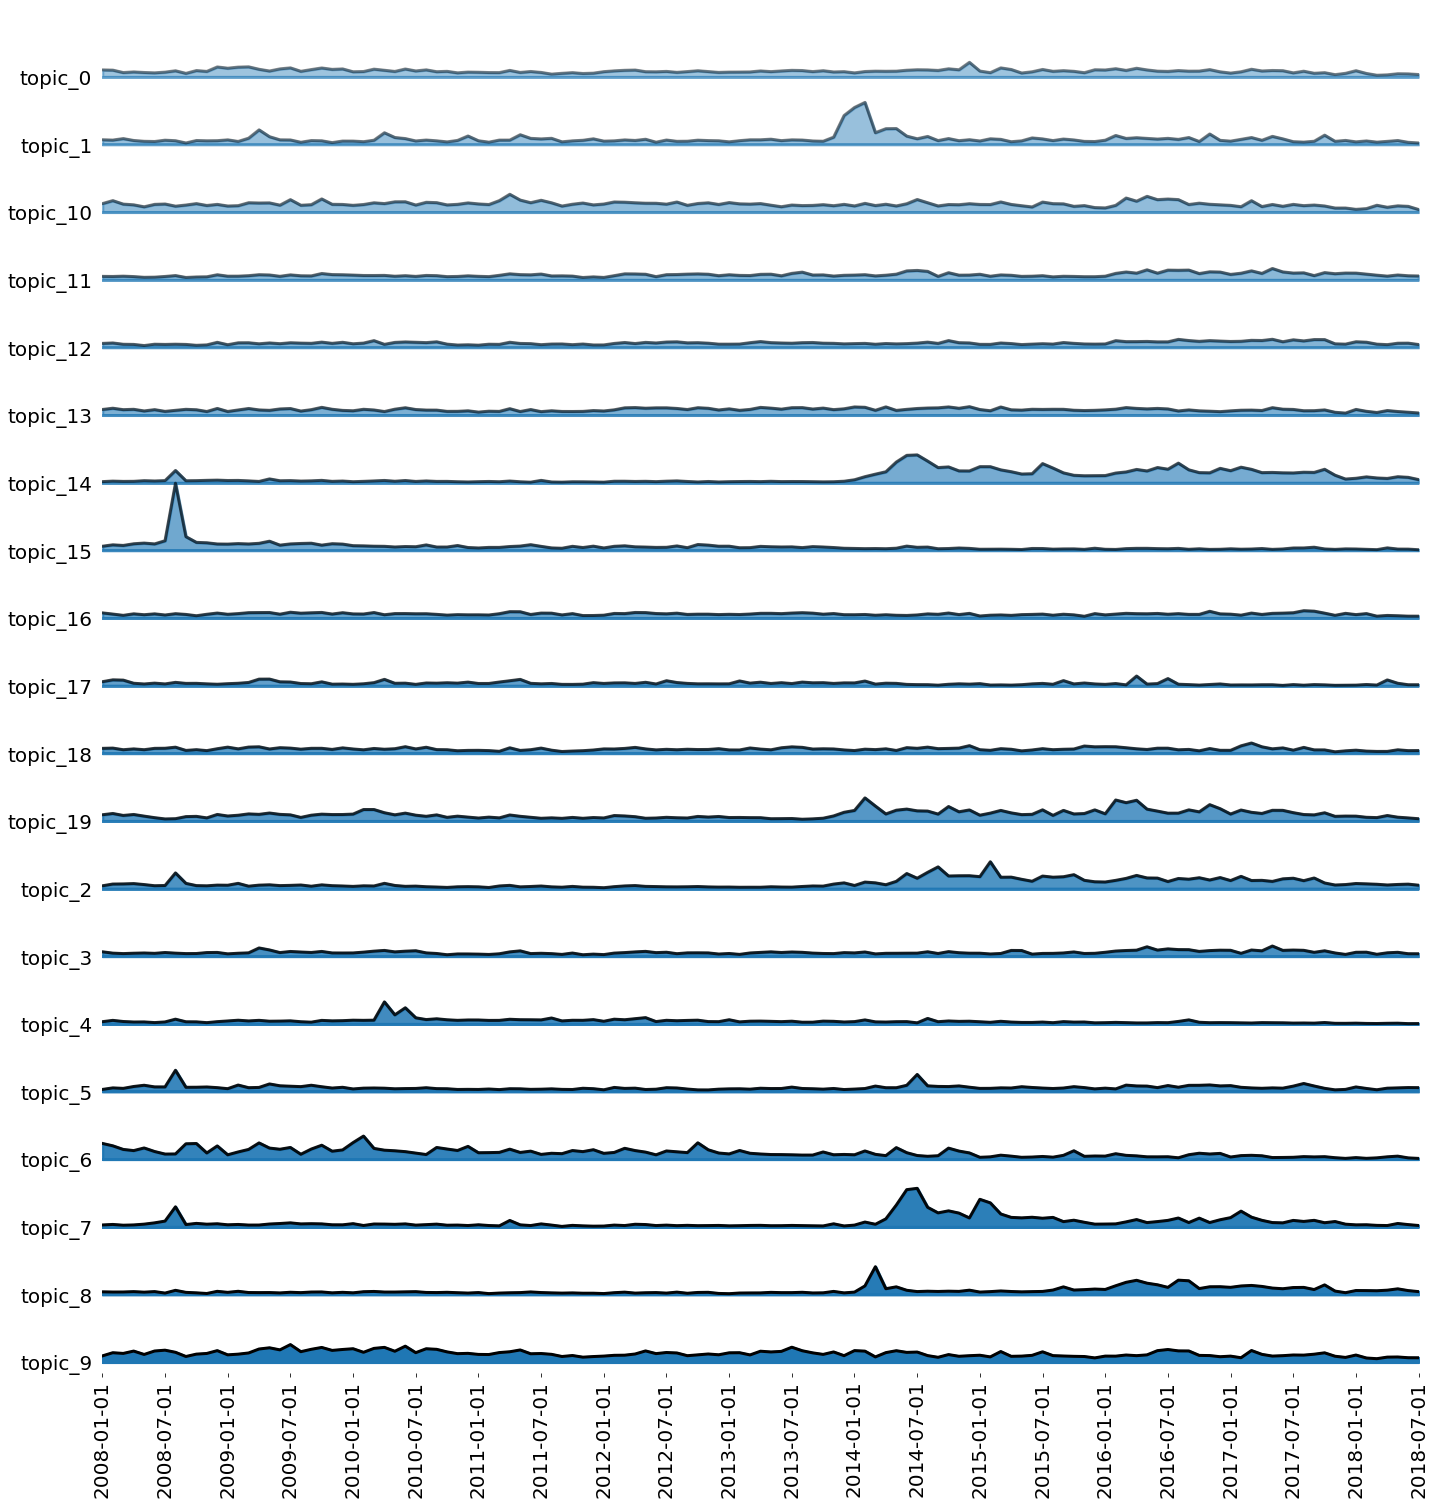

In [199]:
labels = sorted(joined_lenta['date'].unique())
fig_lenta, axes = joypy.joyplot(dd2, by='topic', column='mentions', figsize=(20, 20),
                          xlabelsize=20,ylabelsize=20,
                          overlap=0.4, fill=True,
                          linecolor="k",linewidth=3,
                          kind='values', fade=True, xrot=90,
                          x_range=[i for i in range(len(labels))],
                          background='white');

ticks_labels = {i:t for i, t in enumerate(labels)}
axes[-1].set_xticks([k for k, v in ticks_labels.items() if k % 6 == 0])
ticks = axes[-1].get_xticks()
axes[-1].set_xticklabels([ticks_labels.get(i, 'stop') for i in ticks]);

In [202]:
fig_lenta.savefig(f"data/lenta/lenta_{'-'.join(name_dataset_lenta.split('.'))}_joypy")

* ## interfax

* prepare

In [203]:
vwpath_interfax = f'data/interfax/vwpath/{name_dataset_interfax}_input_bigartm.vw'

with open(vwpath_interfax, 'w') as fp:
    for text, did in df_interfax[['lemmatized_text', 'docID']].values:
        fp.write('{} | {}\n'.format(did, ' '.join(text)))

In [204]:
id_date_interfax = df_interfax[['docID', 'year', 'month']].copy()

* collect batchs and collect the dictionary

In [222]:
batches_path_interfax = f'data/interfax/batches/{name_dataset_interfax}'

if not os.path.exists(batches_path_interfax):
    print('create folder...\n')
    os.makedirs(batches_path_interfax)
    
batch_vectorizer_interfax = artm.BatchVectorizer(data_path=vwpath_interfax,
                                              data_format='vowpal_wabbit',
                                              target_folder=batches_path_interfax)

print(batch_vectorizer_interfax)

create folder...

artm.BatchVectorizer(data_path="data/interfax/batches/Byvsij_SSSR", num_batches=45)


In [223]:
dictionary_interfax = artm.Dictionary()
dictionary_interfax.gather(data_path=batches_path_interfax)

dictionary_interfax.filter(min_tf=10, max_df_rate=0.1) #int(4.5e5)

artm.Dictionary(name=45a27a0c-5f57-48ac-a30f-deffb0979ab5, num_entries=18002)

In [224]:
model_interfax = artm.ARTM(num_topics=select_topics, dictionary=dictionary_interfax, show_progress_bars=True)

# scores
model_interfax.scores.add(artm.PerplexityScore(name='PerplexityScore', dictionary=dictionary_interfax))
model_interfax.scores.add(artm.SparsityThetaScore(name='SparsityThetaScore'))
model_interfax.scores.add(artm.SparsityPhiScore(name='SparsityPhiScore'))

# 1st regularizer
model_interfax.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SparsePhi', tau=-1.0)) #-0.1
model_interfax.fit_offline(batch_vectorizer=batch_vectorizer_interfax, num_collection_passes=5)

# 2st regularizer
model_interfax.regularizers.add(artm.SmoothSparseThetaRegularizer(name='SparseTheta', tau=-0.5))
model_interfax.fit_offline(batch_vectorizer=batch_vectorizer_interfax, num_collection_passes=15)

# 3st regularizer
model_interfax.regularizers.add(artm.DecorrelatorPhiRegularizer(name='DecorrelatorPhi', tau=1.5e+5))

model_interfax.fit_offline(batch_vectorizer=batch_vectorizer_interfax, num_collection_passes=15)

print(f"\tSparsityThetaScore: {model_interfax.score_tracker['SparsityThetaScore'].last_value}")
print(f"\tSparsityPhiScore: {model_interfax.score_tracker['SparsityPhiScore'].last_value}")
print(f"\tPerplexityScore: {model_interfax.score_tracker['PerplexityScore'].last_value}")


	SparsityThetaScore: 0.6884685754776001
	SparsityPhiScore: 0.8751111030578613
	PerplexityScore: 1982.767822265625


* print top words for each topics

In [225]:
phi = model_interfax.get_phi()
phi['word'] = phi.index

for col in phi.columns:
    if col != 'word':
        print(f"{col}: {phi[[col, 'word']].sort_values(by=col, ascending=False)['word'].values[:10]}")

topic_0: ['миллион' 'миллиард' 'газа' 'поставка' 'предприятие' 'средство' 'цена'
 'сумма' 'система' 'электроэнергия']
topic_1: ['здание' 'корреспондент' 'участник' 'милиция' 'площадь' 'улица'
 'активист' 'беспорядок' 'майдан' 'передавать']
topic_2: ['огонь' 'обстрел' 'позиция' 'прекращение' 'линия' 'пункт' 'минский' 'мм'
 'конфликт' 'режим']
topic_3: ['оборона' 'крым' 'военнослужащий' 'войско' 'учение' 'нато' 'оон'
 'граница' 'база' 'состав']
topic_4: ['киргизия' 'азербайджан' 'обсе' 'наблюдатель' 'миссия' 'бишкек'
 'временной' 'снг' 'бакиев' 'киргизский']
topic_5: ['абхазия' 'армения' 'грузинский' 'тбилиси' 'ереван' 'армянский'
 'абхазский' 'премьерминистр' 'член' 'полицейский']
topic_6: ['белоруссия' 'гуманитарный' 'минск' 'белорусский' 'граница' 'помощь'
 'груз' 'пункт' 'мчс' 'лукашенко']
topic_7: ['взрыв' 'погибнуть' 'пострадавший' 'больница' 'дом' 'погибший'
 'состояние' 'пожар' 'пострадать' 'ребёнок']
topic_8: ['выбор' 'верховный' 'закон' 'избирательный' 'фракция' 'кандидат' 'выб

In [226]:
theta_interfax = model_interfax.transform(batch_vectorizer=batch_vectorizer_interfax)
theta_interfax = theta_interfax.T

theta_interfax.head(2)

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19
10000,0.0,0.009707,0.0,0.019001,0.0,0.0,0.193269,0.0,0.000000,0.540782,0.0,0.025573,0.000000,0.000000,0.0,0.0,0.176416,0.026735,0.008518,0.000000
10001,0.0,0.000000,0.0,0.006426,0.0,0.0,0.003425,0.0,0.206839,0.000000,0.0,0.446118,0.069354,0.238624,0.0,0.0,0.000000,0.000000,0.009890,0.019323


In [227]:
joined_interfax = id_date_interfax.join(theta_interfax)
joined_interfax.head(2)

,docID,year,month,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,...,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19
0,0,2008,2,0.453495,0.0,0.0,0.0,0.024996,0.003125,0.060141,...,0.0,0.13455,0.095006,0.181878,0.0,0.0,0.020969,0.000416,0.017951,0.0
1,1,2008,2,0.627228,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,0.0,0.00000,0.087386,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0


In [228]:
topics = ['topic_{}'.format(i) for i in range(select_topics)]
gb_interfax = joined_interfax.groupby(['year', 'month'])[topics].sum()

print(f'gb.shape: {gb_interfax.shape}')
gb_interfax.head()

gb.shape: (131, 20)


topic_0    topic_1   topic_2    topic_3    topic_4    topic_5  \
year month                                                                    
2008 2       5.760472   2.876415  0.365309   2.000219   1.773700  11.270631   
     3      27.613873  13.503314  5.757678  10.927513  10.177081  17.861046   
     4      18.593994  13.269810  2.144561  21.140678   6.592179  24.168394   
     5      13.880780  15.108719  2.322244  33.342564  10.137774  35.213306   
     6      13.390246  12.919604  3.046312  18.689220   4.939569  19.459402   

              topic_6    topic_7    topic_8    topic_9   topic_10   topic_11  \
year month                                                                     
2008 2       1.035368   6.568272  13.723845   1.498193   7.870963   9.503622   
     3       7.308514  22.544352  27.022629   9.325748  20.698027  31.163540   
     4       6.466545  19.278614  22.966436  15.287906  14.023268  32.193321   
     5      10.163095  33.872044  31.864641  11.537979  11.186216  43.248230   
     6       8.768039  40.469925  15.733141  12.161125  12.824109  31.492813   

             topic_12   topic_13  topic_14   topic_15   topic_16   topic_17  \
year month                                                                    
2008 2       1.400150   9.628122  0.730038   9.761053   3.643828   6.105114   
     3      17.304684  48.494213  2.825207  27.107840  15.281837  24.424259   
     4      15.129905  48.056385  2.817280  29.208839  17.769423  11.382945   
     5      12.597514  48.008492  6.013093  35.273350  22.231909  13.846569   
     6      12.711199  44.283005  2.151751  33.463852  18.037966   8.120152   

             topic_18  topic_19  
year month                       
2008 2       3.458428  2.026255  
     3       8.627444  8.031202  
     4       7.582135  8.927382  
     5      11.334116  6.817364  
     6       8.344029  7.994543

* pygal

In [229]:
import pygal
from IPython.display import SVG, HTML

html_pygal = """
<!DOCTYPE html>
<html>
  <head>
  <script type="text/javascript" src="http://kozea.github.com/pygal.js/javascripts/svg.jquery.js"></script>
  <script type="text/javascript" src="http://kozea.github.com/pygal.js/javascripts/pygal-tooltips.js"></script>
    <!-- ... -->
  </head>
  <body>
    <figure>
      {pygal_render}
    </figure>
  </body>
</html>
"""

In [ ]:
line_chart_interfax = pygal.StackedLine(fill=True, show_dots=False)
line_chart_interfax.title = 'Topics'
for topic in topics:
    line_chart_interfax.add(topic, gb_interfax[topic].values)
    
HTML(html_pygal.format(pygal_render=line_chart_interfax.render(is_unicode=True)))

In [231]:
line_chart_interfax.render_to_file(f"data/interfax/interfax_{'-'.join(name_dataset_interfax.split('.'))}_pygal.svg")

* joypy

In [232]:
import joypy # !pip install joypy

In [233]:
joined_interfax['date'] = ['{}-{:02d}-01'.format(a, b) for a, b in joined_interfax[['year', 'month']].values]
cols = [c for c in joined_interfax.columns if c.startswith('topic')]

joined_interfax.head()

,docID,year,month,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,...,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19,date
0,0,2008,2,0.453495,0.0000,0.0,0.0,0.024996,0.003125,0.060141,...,0.134550,0.095006,0.181878,0.000000,0.000000,0.020969,0.000416,0.017951,0.000000,2008-02-01
1,1,2008,2,0.627228,0.0000,0.0,0.0,0.000000,0.000000,0.000000,...,0.000000,0.087386,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2008-02-01
2,2,2008,2,0.037127,0.0000,0.0,0.0,0.000000,0.000000,0.013841,...,0.000000,0.157208,0.684762,0.000000,0.000000,0.000000,0.000000,0.000000,0.107062,2008-02-01
3,3,2008,2,0.000000,0.0462,0.0,0.0,0.000000,0.000000,0.000000,...,0.152312,0.000000,0.135408,0.054331,0.000000,0.000000,0.000000,0.000000,0.000000,2008-02-01
4,4,2008,2,0.000000,0.0000,0.0,0.0,0.000000,0.000000,0.000000,...,0.396592,0.000000,0.000000,0.000000,0.079138,0.046960,0.032437,0.000000,0.007473,2008-02-01


In [234]:
dd = joined_interfax[cols + ['date']].melt('date', var_name='topic', value_name='mentions')
dd = dd[dd['mentions'] > 0]

dd2 = dd.groupby(['date','topic']).sum()
dd2=dd2.reset_index()

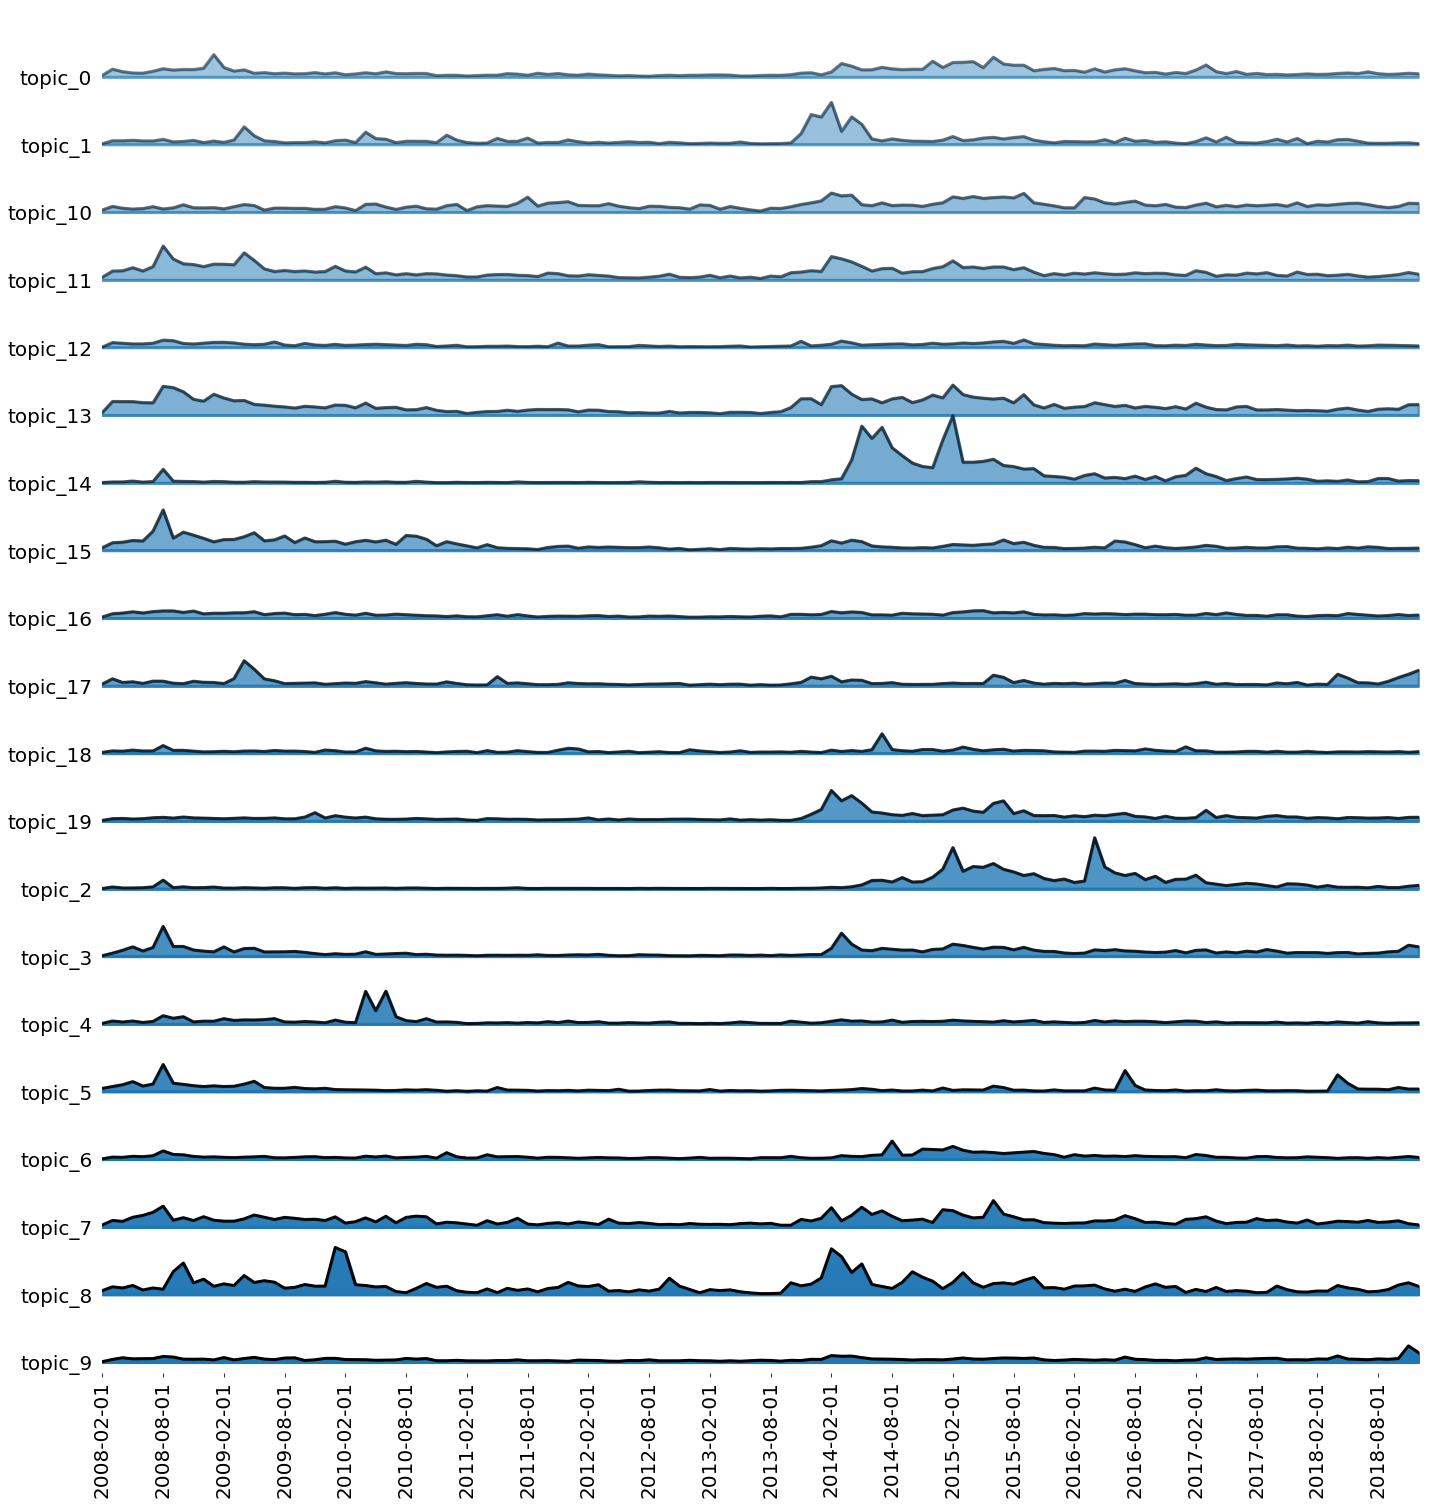

In [235]:
labels = sorted(joined_interfax['date'].unique())
fig_interfax, axes = joypy.joyplot(dd2, by='topic', column='mentions', figsize=(20, 20),
                          xlabelsize=20,ylabelsize=20,
                          overlap=0.4, fill=True,
                          linecolor="k",linewidth=3,
                          kind='values', fade=True, xrot=90,
                          x_range=[i for i in range(len(labels))],
                          background='white');

ticks_labels = {i:t for i, t in enumerate(labels)}
axes[-1].set_xticks([k for k, v in ticks_labels.items() if k % 6 == 0])
ticks = axes[-1].get_xticks()
axes[-1].set_xticklabels([ticks_labels.get(i, 'stop') for i in ticks]);

In [236]:
fig_interfax.savefig(f"data/interfax/interfax_{'-'.join(name_dataset_interfax.split('.'))}_joypy")